In [1]:
# Install the required dependencies, run this cell only if running the notebook on Google Colab
!pip install -q tf-agents

     |████████████████████████████████| 1.2MB 5.9MB/s 


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tf_agents.networks import q_network
from tf_agents.agents.ddpg import ddpg_agent, critic_network, actor_network
from tf_agents.specs import tensor_spec, array_spec
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents import utils
from tf_agents.trajectories import time_step as ts

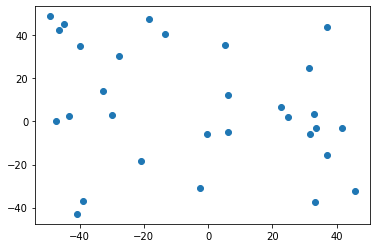

In [7]:
# Number of sensing locations
locations_num = 30

# Size of the map (the map is squared)
map_size = 100.0

# Coordinates of the sensing locations
sensing_locations = (np.random.rand(locations_num, 2) * map_size) - (map_size / 2)

_ = plt.scatter(sensing_locations[:,0], sensing_locations[:,1])

In [ ]:
# Number of drones
drones_num = 10

# Length of a single cycle in seconds
cycle_length = 1.0

# Maximum speed of drones in points / seconds
max_speed = 0.5

# Definition of the global state

# Coordinates of the drones locations
drones_locations = np.zeros((drones_num, 2), dtype=float)

# Amounts of sensing data to send per drone
sensing_data_amounts = np.zeros(drones_num, dtype=float)

# AoIs (age of information) per sensing location. Denotes the last cycle in which
# any drone performed sensing at a specific sensing location
aois = np.zeros(locations_num, dtype=int)

# Indices of the chosen locations per drone. They are chosen in the decision cycles.
# The initial values are not significant.
chosen_locations = np.zeros(drones_num, dtype=int)


# Returns the AoI of the given location
def get_location_aoi(cycle, location_index):
    return (cycle * cycle_length) - ((aois[location_index] // cycle_length) * cycle_length)

# Returns the trajectory for the current cycle 
def get_trajectory(drone_index):
    chosen_location_index = chosen_locations[drone_index]
    chosen_location = sensing_locations[chosen_location_index]
    drone_location = drones_locations[drone_index]
    distance = np.linalg.norm(chosen_location - drone_location)
    if distance <= max_speed * cycle_length:
        return chosen_location - drone_location
    else:
        return ((chosen_location - drone_location) / distance) * max_speed * cycle_length

In [ ]:
# Simplifying transmission step: only considering a bandwidth and a total amount of
# data for every location. Assumption: tasks are equal, so the amount of data is the same.

# Transmission bandwidth per cycle
bandwidth = 0.5

# Total amount of sensing data per location
total_location_data = 3.0

# Amount of data transmissible per cycle 
data_transmission_cycle = bandwidth * cycle_length

ArraySpec(shape=(1,), dtype=dtype('int32'), name='action')

In [26]:
'''
Using Deep Q Learning. Having current drone location (x,y), 
potential sensing location (x',y') (could also directly consider distance
between the two locations) and AoI of the sensing location
as features, the network should output a Q value. The higher
the value the better this sensing location choice. Executing the network
at the decision cycle for every sensing location and choosing the one
that outputs the highest Q value. After each decision, the Q network
should be updated by performing backpropagation and considering the error.
'''

class DurpEnv(py_environment.PyEnvironment):
    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=locations_num-1, name='action')
        self._observation_spec = 
        {
            "position": array_spec.ArraySpec(shape=(drones_num,), dtype=np.int32),
            "transmission_data": array_spec.ArraySpec(shape=(drones_num,), dtype=np.int32),
            "AoI": array_spec.ArraySpec(shape=(locations_num,), dtype=np.int32),
            "target": array_spec.ArraySpec(shape=(locations_num,), dtype=np.int32),
        }
        self._state = 0 # TODO: not sure if we need this
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = 0
        self._episode_ended = False
        return ts.restart(np.array([self._state], dtype=np.int32))

    def _step(self, action):

        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        # TODO: return some pair (state, reward)
        #if response == ActionResult.GAME_COMPLETE:
            #return timeStep.termination(self._game.game_state(), 10)
        #return timeStep.transition(self._game.game_state(), reward=-0.3, discount=1.0)


learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

durp_env = DurpEnv()

train_env = tf_py_environment.TFPyEnvironment(durp_env)

actor_net = actor_network.ActorNetwork(
    train_env.observation_spec(), 
    train_env.action_spec(),
    name='DurpActorNetwork'
)

critic_net = critic_network.CriticNetwork(
    train_env.observation_spec(), 
    output_activation_fn=tf.keras.activations.sigmoid,
    activation_fn=tf.nn.relu,
    name='DurpCriticNetwork'
)

'''
q_net = q_network.QNetwork(
  train_env.observation_spec(),
  train_env.action_spec(),
  fc_layer_params=(100,))'''

agent = ddpg_agent.DdpgAgent(
  train_env.time_step_spec(),
  train_env.action_spec(),
  critic_network=critic_net,
  actor_network=actor_net,
  critic_optimizer=optimizer,
  #td_errors_loss_fn=utils.common.element_wise_squared_loss,
  train_step_counter=tf.Variable(0)
  )

agent.initialize()

In [ ]:
# Number of total cycles for the simulation
cycles_num = 500

# Running simulation (one cycle at a time for every drone)
for cycle in range(1, cycles_num + 1):
    for drone in range(drones_num):
        # TODO: select next location in some way during decision cycle
        aoi = get_location_aoi(cycle, chosen_locations[drone])
        if aoi == cycle_length: # Decision cycle
            pass
        elif (drones_locations[drone] != chosen_locations[drone]).all(): # Empty cycle
            trajectory = get_trajectory(drone)
            new_location = drones_locations[drone] + trajectory
            # Updating drone location
            np.insert(drones_locations, drone, new_location, axis=0)
        elif sensing_data_amounts[drone] == 0.0: # Sensing cycle
            # Updating drone sensing data remaining amount
            np.insert(sensing_data_amounts, drone, total_location_data, axis=0)
        else: # Transmission cycle
            # Updating drone sensing data remaining amount
            np.insert(sensing_data_amounts, drone, 
                np.max(sensing_data_amounts[drone] - data_transmission_cycle, 0.0), axis=0)
            # Updating the AoI if the transmission has been completed
            if sensing_data_amounts[drone] == 0.0:
                np.insert(aois, chosen_locations[drone], cycle, axis=0)

